Import:

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
#import seaborn as sns
from random import gauss
#from countryinfo import CountryInfo

Parameters:

In [2]:
# Total population, N.
N = 8.5*10**6
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 246, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
D0 = 0 #no death at t0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 2.4/11, 1./11 #multiplied by 36 
print("R_0 =", beta/gamma)

#mortality rate
m = 3./100

#Nb days of simulation
D = 300
time = np.linspace(0, D, D)

#Hospital_capacity
avail=0.5
beds = 40000*avail
resp = 777

#Quarantine: isolation of symptomatic people
Quarantine = {"no":0, "yes":0.75} #yes: percentage of sick people showing symptoms

#Hygiene level
Hygiene = {"dirty":0.5, "normal":1.0, "medium":1.5, "high":2.0} 

#Supermarket frequency
shopping_freq = {"very low":1, "low": 2,"normal":3,"high":5,"very high":6,"everyday":7} #number of days you go shopping/week

#Social distancing
pop_dist = {"100%":1, "90%":0.9, "75%":0.75, "50%":0.5, "25%":0.25, "0%":0} # % of the population practicing social distancing
level_dist = {"isolation":0, "very high": 1, "high":2, "moderate":4, "low":6, "none":8} #how many ppl you see in 1 day if you are distancing
#radius = 0, r/8, 3*r/8, 5*r/8, r
#beta = 0, b/64, 9*b/64, 25*b/64, b


R_0 = 2.4


Computation:

In [3]:
#initialize array
S_array = np.ones(D)*S0
I_array = np.ones(D)*I0
R_array = np.ones(D)*R0
De_array = np.zeros(D)
Severe   = np.zeros(D)
Critical = np.zeros(D)

# Initial conditions vector
y0 = S0, I0, R0, D0
#solving one step at a time with odeint
t=[0,1]


#SIRD classical model
def deriv_basic(y, t, N, beta, gamma, day):
    #differential equations without mesures
    
    S, I, R, De = y
   
    #risk people
    Severe    = I* 0.15 #require hosp
    Critical  = I* 0.05 #require resp
    
    #check hospital capacity
    if Critical > resp:
        m_r = 2.5*m
    elif Severe+Critical > beds: 
        m_r = 2*m
    else: m_r = m
    
    
    #diff eq
    dSdt = -beta * S*I/ N
    dIdt = beta * S*I / N - gamma * I
    dRdt = (1-m_r)*gamma * I
    dDedt = gamma*m_r*I
    
    return dSdt, dIdt, dRdt, dDedt

    
# The SIRD model differential equations with mesures
def deriv(y, t, N, beta, gamma, day, StartQ, Q, current_hygiene, StartH, current_shop, 
        dist, StartD, dayBTN): 
    S, I, R, De = y
    
    #quarantined people
    impact_Q = Quarantine[Q]
    q=0
    if day >= StartQ:
        q = I*impact_Q
        
       
    #risk people
    Severe    = I* 0.15 #require hosp
    Critical  = I* 0.05 #require resp
    
    
    #check hospital capacity
    if Critical > resp:
        m_r = 2.5*m
    elif Severe+Critical > beds: 
        m_r = 2*m
    else: m_r = m
      
    #adapt beta to hygiene
    h_impact = Hygiene[current_hygiene]
    if day >= StartH:
        beta = beta/h_impact
        
    #adapt beta to supermarket frequency
    shop_impact = shopping_freq[current_shop]
    beta = beta/2**(np.log(shopping_freq["normal"]/shop_impact)/np.log(5))
    #everytime shopping freqency is divided by 5, beta/2
   
    #social distancing
    dist_impact = [pop_dist[dist[0]], level_dist[dist[1]]]
    beta2 = 0
    I1 = I
    I2 = 0
    if day >= StartD:
        beta2 = beta*dist_impact[1]**2/64. #beta of ppl distancing
        I1 = I*(1-dist_impact[0]) #proportion of infected not distancing
        I2 = I*dist_impact[0] #proportion of ppl distancing
        
    #diff eq
    dSdt = -(beta * S * I1 + beta2 * S * I2 - beta * S * q) / N
    dIdt = (beta * S * I1 + beta2 * S * I2 - beta * S * q)/ N - gamma * I
    dRdt = (1-m_r)*gamma * I
    dDedt = gamma*m_r*I
    

    return dSdt, dIdt, dRdt, dDedt

def sir_no_mesures(sim_length, deriv_basic, y0, t, N, beta, gamma):
    
    S0, I0, R0, D0 = y0
    S_array = np.ones(sim_length)*S0
    I_array = np.ones(sim_length)*I0
    R_array = np.ones(sim_length)*R0
    De_array = np.zeros(sim_length)
    Severe   = np.zeros(sim_length)
    Critical = np.zeros(sim_length)
    
    
    for i in range(1, sim_length):
        ret = odeint(deriv_basic, y0, t, args=(N, beta, gamma, i ))
        S, I, R, De = ret.T
        
        S_array[i]   = S[1]
        I_array[i]   = I[1]
        R_array[i]   = R[1]
        De_array[i]  = De[1]
        Severe[i]    = I[1]* 0.15 #require hosp
        Critical[i]  = I[1]* 0.05 #require resp
        y0 = S[1], I[1], R[1], De[1]
        
    #information for the table
    data = [[N], [I0], [beta/gamma], [m], ["never"], [float("inf")], [beds], [resp], ["normal"]]
    
    return S_array, I_array, R_array, De_array, Severe, Critical, data
                     
                 
def sir(sim_length, deriv, deriv_basic, y0, t, N, beta, gamma, StartQ, Q, current_hygiene, StartH, current_shop, 
        dist, startD, DayBTN):
    # Integrate the SIRD equations over the time grid, t.
    for i in range(1,sim_length):
        if i >= DayBTN:
            ret = odeint(deriv_basic, y0, t, args=(N, beta, gamma, i))
        else:
            ret = odeint(deriv, y0, t, args=(N, beta, gamma, i, StartQ, Q, current_hygiene, StartH, current_shop, 
                        dist, startD, DayBTN))
    
        S, I, R, De = ret.T
    
        S_array[i]   = S[1]
        I_array[i]   = I[1]
        R_array[i]   = R[1]
        De_array[i]  = De[1]
    
        Severe[i]    = I[1]* 0.15 #require hosp
        Critical[i]  = I[1]* 0.05 #require resp
    
        y0 = S[1], I[1], R[1], De[1]
        
     #information for tables
    quarantine_start = "Never"
    if Q != 0:
        quarantine_start = StartQ

    data = [[N], [I0], [beta/gamma], [m], [quarantine_start], [DayBTN], [beds], [resp], [current_hygiene]]
    
    return S_array, I_array, R_array, De_array, Severe, Critical, data

def compute_saving(De, De_nm, R, R_nm, N, sim_length):
    #compute how many people saved from death and infection
    
    #infections:
    Tot_i= R[len(R)-1]
    Tot_i_nm = R_nm[len(R_nm)-1]
    Saved_i = Tot_i_nm - Tot_i
    Saved_i = Saved_i/N
    
    #deaths
    Tot_d = De[len(De)-1]
    Tot_d_nm = De_nm[len(De_nm)-1]
    Saved_d = Tot_d_nm - Tot_d
    Saved_d = Saved_d/N
    return Saved_i, Saved_d
    

S_nm, I_nm, R_nm, De_nm, Se_nm, Cr_nm, data_nm= sir_no_mesures(D, deriv_basic, y0, t, N, beta, gamma)
S, I, R, De, Se, Cr, data = sir(D, deriv, deriv_basic, y0, t, N, beta, gamma, 100, "yes", "medium", 50, "normal", 
                            ["50%","high"], 80, 120)

Saved_i, Saved_d = compute_saving(De, De_nm, R, R_nm, N, D)

print("Congratulations! You saved", Saved_i, "people from being infected and", Saved_d, "people from dying today")

Congratulations! You saved 0.051981768507350895 people from being infected and 0.004185362200134174 people from dying today


Plots

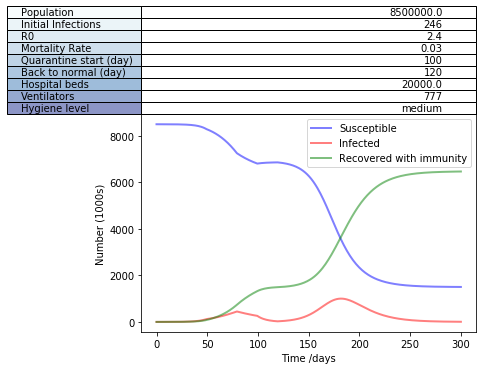

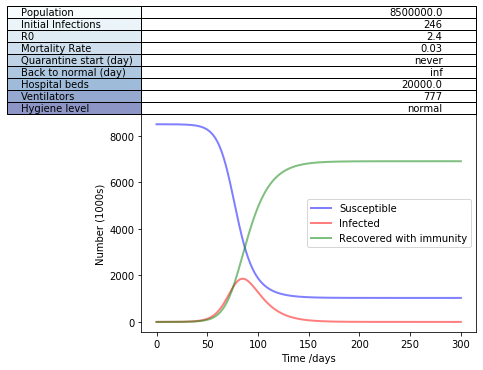

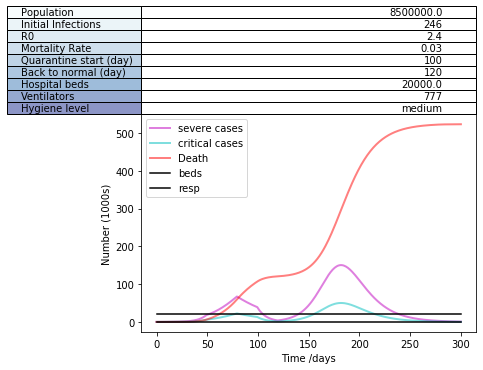

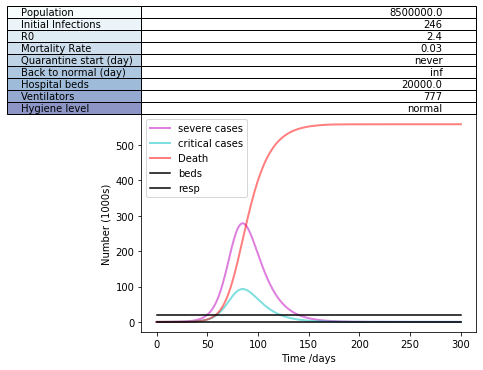

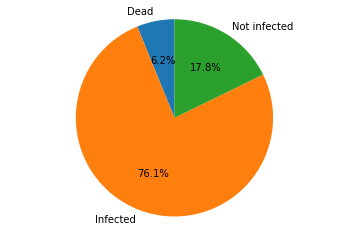

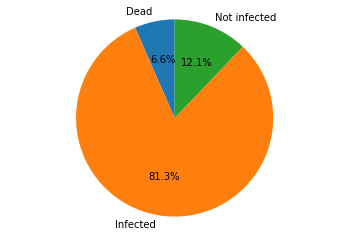

In [4]:
def plot_sir(S, I, R, time, rows, data):
    #plot SIR 
    fig1 = plt.figure(facecolor='w')
    plt.plot(time, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(time, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    plt.plot(time, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    plt.xlabel('Time /days')
    plt.ylabel('Number (1000s)')
    
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    plt.table(cellText=data, rowLabels=rows, rowColours=colors, loc='top')
    legend = plt.legend()
    plt.show()
    #plt.savefig('NoMesSIR.png', bbox_inches="tight", pad_inches=1)

#plots severe, critical case and deaths
def plot_letality(Severe, Critical, Death, time, beds, resp, data, rows):
    fig2 = plt.figure(facecolor='w')
    plt.plot(time, Severe/1000,  'm', alpha=0.5, lw=2, label='severe cases')
    plt.plot(time, Critical/1000, 'c', alpha=0.5, lw=2, label='critical cases')
    plt.plot(time, Death/1000, 'r', alpha=0.5, lw=2, label='Death')


    plt.plot([0,len(time)], [beds/1000, beds/1000], 'k', label='beds')
    plt.plot([0,len(time)], [resp/1000, resp/1000],'k', label='resp')
    
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
    plt.table(cellText=data, rowLabels=rows, rowColours=colors, loc='top')

    plt.xlabel('Time /days')
    plt.ylabel('Number (1000s)')
    legend = plt.legend()
    #plt.savefig('NoMesD.png', bbox_inches="tight", pad_inches=1)

#pie chart Infected/Dead
def pie_id(De, R, N):
    Tot_death = De[len(De)-1]
    Percentage_death = Tot_death/N*100
    Tot_infected = R[len(R)-1]
    Percentage_infected = Tot_infected/N*100

    #Pie Chart
    labels = 'Dead', 'Infected', 'Not infected'
    sizes = [Percentage_death, Percentage_infected, 100-Percentage_death-Percentage_infected]
    #explode = (0.1, 0.1, 0)  

    fig3, ax3 = plt.subplots()
    ax3.pie(sizes, explode=None, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
    ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    #plt.savefig('NoMesPie.png')

    plt.show()
    
#Info for table
rows = ("Population", "Initial Infections", "R0", "Mortality Rate", "Quarantine start (day)", "Back to normal (day)",
        "Hospital beds", "Ventilators", "Hygiene level")

#plot SIRs
plot_sir(S, I, R, time, rows, data)
plot_sir(S_nm, I_nm, R_nm, time, rows, data_nm) #no mesures sir


#Plot deaths and critical
plot_letality(Se, Cr, De, time, beds, resp, data, rows)
plot_letality(Se_nm, Cr_nm, De_nm, time, beds, resp, data_nm, rows) #no mesures


#Pie chart Infected-dead
pie_id(De, R, N)
pie_id(De_nm, R_nm, N)

Users parameters

In [5]:
def simulateUsersbehaviour(friends, central_loc, hands, sim_length, deriv, deriv_basic, y0, t, N, beta, gamma):
    #simulates what would happen if everyone had the same behaviour as the user
    #the number of people he has seen outside his household (friends),the number of times he's been to a highly frequented 
    #location in the past week (central_loc) and the number of times he washed his hand in the last day (hands)
    #returns the deaths, infections, immunes, suceptibles, severe and critical cases, number of ppl saved

    
    #finding level of social distancing
    if friends == 0:
        level = "isolation"
    elif 0 < friends <=1.5:
        level = "very high"
    elif 1.5 < friends <= 2.5:
        level = "high"
    elif 2.5 < friends <= 5:
        level = "moderate"
    elif 5 < friends <= 7:
        level = "low"
    else:
        level = "none"  
    dist = ["100%",level]
    
    #finding level of hygiene
    if hands < 3:
        curr_hygiene = "dirty"
    elif 3 <= hands < 5:
        curr_hygiene = "normal"
    elif 5 <= hands < 10:
        curr_hygiene = "medium"
    else:
        curr_hygiene = "high"
    
    #finding frequency of central location
    if central_loc <=1:
        curr_shop = "very low"
    elif 1 < central_loc <= 2.5:
        curr_shop = "low"
    elif 2.5 < central_loc <= 4:
        curr_shop = "normal"
    elif 4 < central_loc <= 5.5:
        curr_shop = "high"
    elif 5.5 < central_loc < 6.5:
        curr_shop = "very high"
    else:
        curr_shop = "everyday"
    
    return sir(sim_length, deriv, deriv_basic, y0, t, N, beta, gamma, float('inf'), "no", curr_hygiene, 0, 
               curr_shop, dist,0, float('inf'))

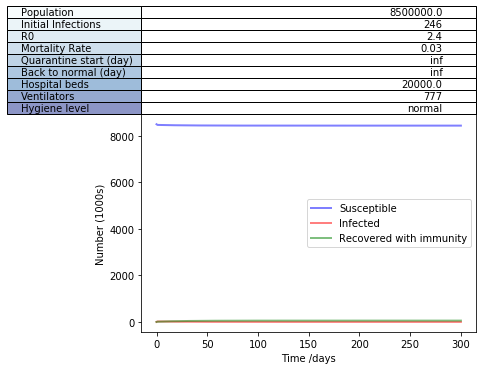

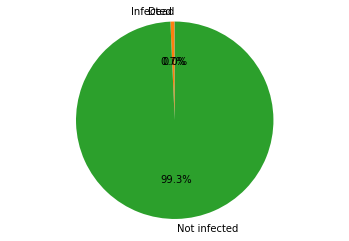

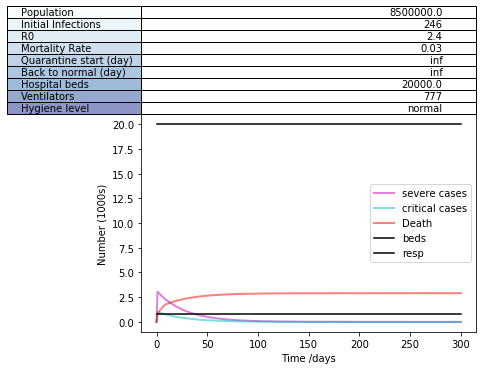

In [16]:
#testing above function
y0 = 8471770, 21100, 6415, 715
friends = 5
central_loc = 3
hands = 3

S, I, R, De, Sev, Crit, data = simulateUsersbehaviour(friends, central_loc, hands, D, deriv, deriv_basic, y0, t, N, beta, gamma)
plot_sir(S, I, R, time, rows, data)
pie_id(De, R, N)
plot_letality(Sev, Crit, De, time, beds, resp, data, rows)

Animation (not working yet)

In [36]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)

def animate(i):
    data_pd = pd.DataFrame(I_array[1:]).astype(float)
    data_pd.columns = {"time"}
    data =data_pd[:int(i+1)] #select data range
    p = sns.lineplot(x=data.index, y=data["time"], data=data, color="r")
    p.tick_params(labelsize=17)
    plt.setp(p.lines,linewidth=7)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=17, repeat=True)
ani.save('TestAnim.mp4', writer=writer)

NameError: name 'fig' is not defined

In [2]:
from countryinfo import CountryInfo
country = CountryInfo('Singapore')
country.population()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 49: character maps to <undefined>